**AtliQ Hardware: Customer Analysis**

Anna Nesterenko, junior analyst, TripleTen World Consultancy

The project aims to provide deep analysis of AtliQ Hardware’s customers by segmenting them and
understanding their purchasing behaviors to provide actionable insights for increasing
customer engagement and improving sales strategies.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
conn = sqlite3.connect('atliq_db.sqlite3')

In [3]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)
print(tables)

                      name
0             dim_customer
1              dim_product
2        fact_pre_discount
3  fact_manufacturing_cost
4         fact_gross_price
5       fact_sales_monthly


Data set contains 5 tables.

In [4]:
#check the names of all tables in the database
def get_table_structure(table_name):
    query = f"PRAGMA table_info({table_name});"
    return pd.read_sql_query(query, conn)

#check column details for each table
tables_list = ['dim_customer', 'dim_product', 'fact_pre_discount', 
               'fact_manufacturing_cost', 'fact_gross_price', 'fact_sales_monthly']

for table in tables_list:
    print(f"\nStructure of {table} table:")
    print(get_table_structure(table))
    df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    print(f"\nMissing values in {table} table:")
    print(df.isnull().sum())


Structure of dim_customer table:
   cid           name     type  notnull dflt_value  pk
0    0  customer_code  INTEGER        0       None   0
1    1       customer     TEXT        0       None   0
2    2       platform     TEXT        0       None   0
3    3        channel     TEXT        0       None   0
4    4         market     TEXT        0       None   0
5    5       sub_zone     TEXT        0       None   0
6    6         region     TEXT        0       None   0

Missing values in dim_customer table:
customer_code    0
customer         0
platform         0
channel          0
market           0
sub_zone         0
region           0
dtype: int64

Structure of dim_product table:
   cid          name  type  notnull dflt_value  pk
0    0  product_code  TEXT        0       None   0
1    1      division  TEXT        0       None   0
2    2       segment  TEXT        0       None   0
3    3      category  TEXT        0       None   0
4    4       product  TEXT        0       None   0
5 

There are some missing values in the fact_sales_monthly.

In [5]:
query = "SELECT * FROM fact_sales_monthly"
fact_sales_monthly_df = pd.read_sql_query(query, conn)

fact_sales_monthly_df_cleaned = fact_sales_monthly_df.dropna()
missing_values_after_cleaning = fact_sales_monthly_df_cleaned.isnull().sum()

fact_sales_monthly_df_cleaned.to_sql('fact_sales_monthly', conn, if_exists='replace', index=False)

missing_values_after_cleaning

date             0
product_code     0
customer_code    0
sold_quantity    0
fiscal_year      0
dtype: int64

The table now contains 67,250 rows (down from 67,251 rows).

Join the key tables (dim_customer, dim_product, and fact_sales_monthly) to prepare the dataset for customer segmentation and purchasing behavior analysis.

In [6]:
#join customer, product, and sales data
query = """
SELECT 
    fc.customer_code, 
    fc.product_code, 
    fc.sold_quantity, 
    fc.date, 
    fc.fiscal_year, 
    dc.customer, 
    dc.platform, 
    dc.channel, 
    dc.region, 
    dp.division, 
    dp.segment, 
    dp.category, 
    dp.product
FROM fact_sales_monthly fc
JOIN dim_customer dc ON fc.customer_code = dc.customer_code
JOIN dim_product dp ON fc.product_code = dp.product_code;
"""

#load the results into a DataFrame
joined_data = pd.read_sql_query(query, conn)
print(joined_data.head())

   customer_code product_code  sold_quantity        date  fiscal_year  \
0     70002017.0  A0118150101           51.0  2017-09-01       2018.0   
1     70002018.0  A0118150101           77.0  2017-09-01       2018.0   
2     70003181.0  A0118150101           17.0  2017-09-01       2018.0   
3     70003182.0  A0118150101            6.0  2017-09-01       2018.0   
4     70006157.0  A0118150101            5.0  2017-09-01       2018.0   

          customer        platform channel region division      segment  \
0  Atliq Exclusive  Brick & Mortar  Direct   APAC    P & A  Peripherals   
1    Atliq e Store      E-Commerce  Direct   APAC    P & A  Peripherals   
2  Atliq Exclusive  Brick & Mortar  Direct   APAC    P & A  Peripherals   
3    Atliq e Store      E-Commerce  Direct   APAC    P & A  Peripherals   
4  Atliq Exclusive  Brick & Mortar  Direct   APAC    P & A  Peripherals   

       category                                            product  
0  Internal HDD  AQ Dracula HDD – 3.5 Inc

In [7]:
#convert date column to datetime format
joined_data['date'] = pd.to_datetime(joined_data['date'])

**CUSTOMER SEGMENTATION**

Customer Distribution Across Regions, Platforms, and Channels

**How many customers are present in each region, platform, and channel**

In [8]:
query = """
SELECT region, platform, channel, COUNT(customer_code) AS customer_count
FROM dim_customer
GROUP BY region, platform, channel
ORDER BY customer_count DESC;
"""
customer_distribution = pd.read_sql_query(query, conn)
print(customer_distribution.head())

  region        platform   channel  customer_count
0     EU  Brick & Mortar  Retailer              76
1   APAC  Brick & Mortar  Retailer              35
2     NA  Brick & Mortar  Retailer              16
3   APAC      E-Commerce  Retailer              14
4     EU      E-Commerce  Retailer              12


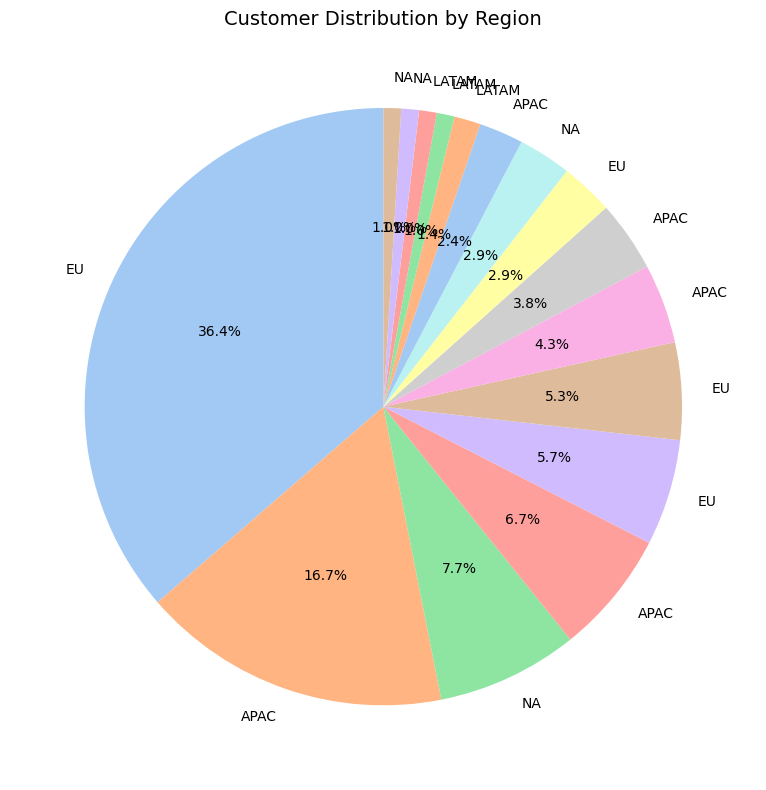

In [9]:
#plot for customer distribution by region
plt.figure(figsize=(8, 8))
plt.pie(customer_distribution['customer_count'], labels=customer_distribution['region'], 
        colors=sns.color_palette("pastel"), autopct='%1.1f%%', startangle=90)
plt.title('Customer Distribution by Region', fontsize=14)
plt.tight_layout()
plt.show()


This chart shows which regions have the most customers.

It helps identify where the company's largest customer base is located.

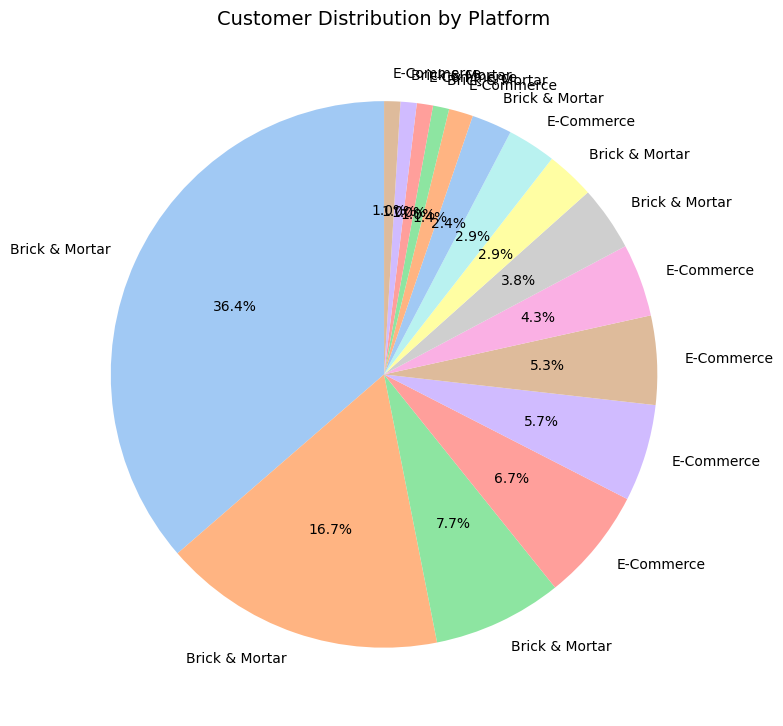

In [10]:
#plot for customer distribution by platform
plt.figure(figsize=(8, 8))
plt.pie(customer_distribution['customer_count'], labels=customer_distribution['platform'], 
        colors=sns.color_palette("pastel"), autopct='%1.1f%%', startangle=90)
plt.title('Customer Distribution by Platform', fontsize=14)
plt.tight_layout()
plt.show()

This chart highlights the percentage of customers using different platforms, such as Brick & Mortar stores or E-Commerce platforms. 

It tells us which platform is more popular among customers.

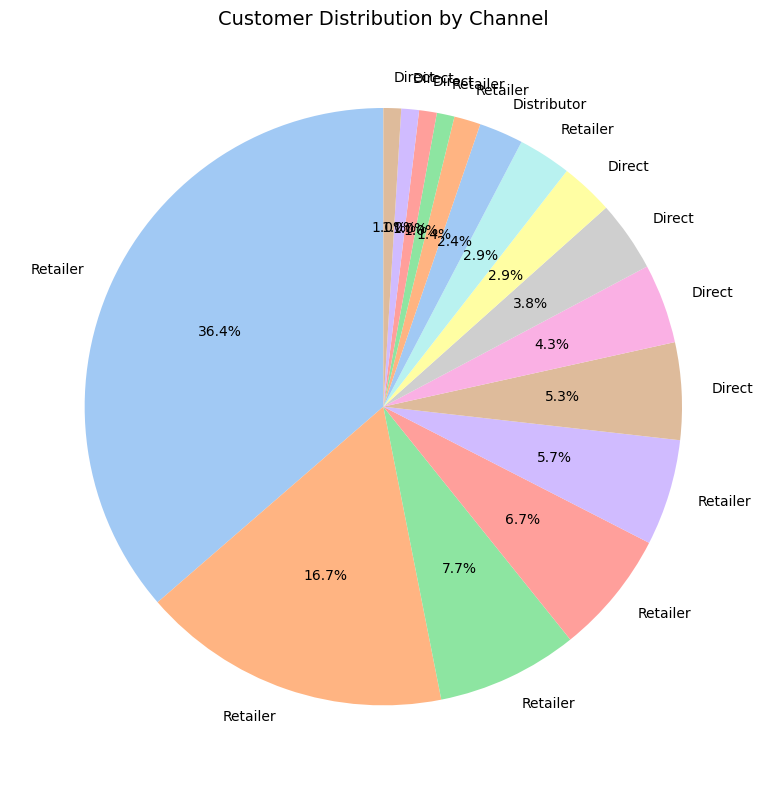

In [11]:
#plot for customer distribution by channel
plt.figure(figsize=(8, 8))
plt.pie(customer_distribution['customer_count'], labels=customer_distribution['channel'], 
        colors=sns.color_palette("pastel"), autopct='%1.1f%%', startangle=90)
plt.title('Customer Distribution by Channel', fontsize=14)
plt.tight_layout()
plt.show()

This shows how customers are spread across sales channels, such as Retailers or Distributors. 

It helps understand which sales channels attract the most customers.

**Order Size and Total Revenue for Each Customer Segment**

In [12]:
query = """
SELECT 
    dc.region,
    dc.platform,
    dc.channel,
    SUM(fsm.sold_quantity) AS total_order_size,
    SUM(fsm.sold_quantity * fgp.gross_price) AS total_revenue
FROM fact_sales_monthly fsm
JOIN dim_customer dc ON fsm.customer_code = dc.customer_code
JOIN fact_gross_price fgp ON fsm.product_code = fgp.product_code AND fsm.fiscal_year = fgp.fiscal_year
GROUP BY dc.region, dc.platform, dc.channel
ORDER BY total_revenue DESC;
"""

segment_revenue = pd.read_sql_query(query, conn)
print(segment_revenue.head())

  region        platform      channel  total_order_size  total_revenue
0   APAC  Brick & Mortar     Retailer          906286.0   2.068067e+07
1     EU  Brick & Mortar     Retailer          586428.0   1.368640e+07
2     NA  Brick & Mortar     Retailer          455203.0   1.044183e+07
3   APAC      E-Commerce     Retailer          448088.0   1.016699e+07
4   APAC  Brick & Mortar  Distributor          443286.0   1.006215e+07


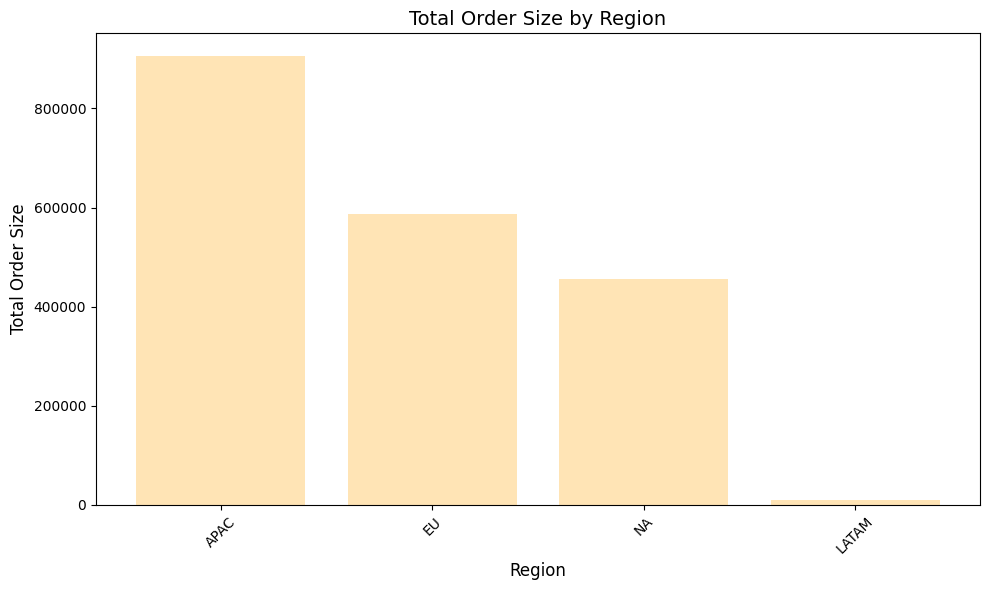

In [13]:
#plot for total order size by region
plt.figure(figsize=(10, 6))
plt.bar(segment_revenue['region'], segment_revenue['total_order_size'], color='moccasin')
plt.title('Total Order Size by Region', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Order Size', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This chart tells us how many products were sold in each region. 

It helps identify which region has the most orders.

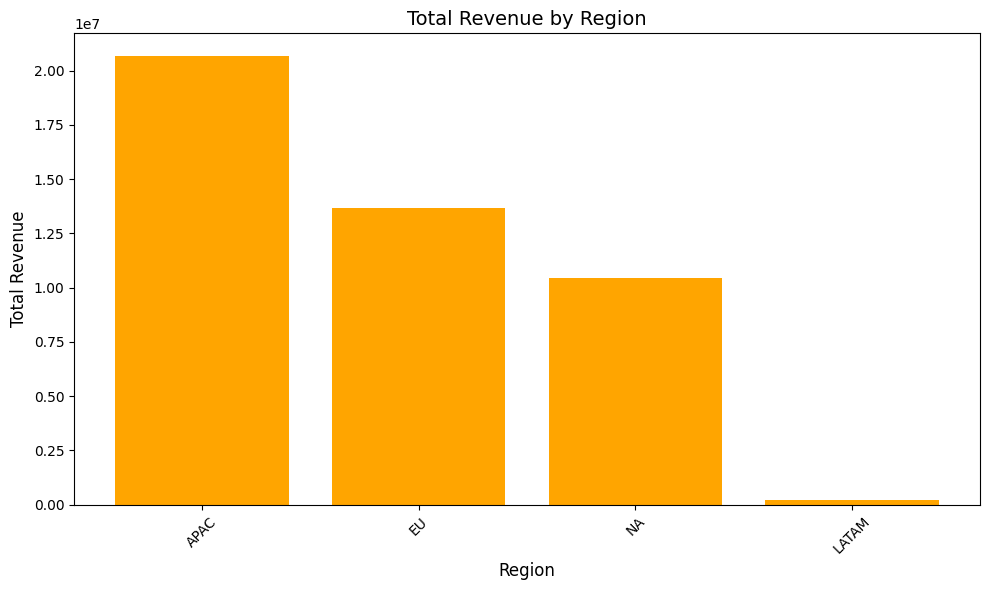

In [14]:
#plot for total revenue by region
plt.figure(figsize=(10, 6))
plt.bar(segment_revenue['region'], segment_revenue['total_revenue'], color='orange')
plt.title('Total Revenue by Region', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This chart shows the total money earned from each region.

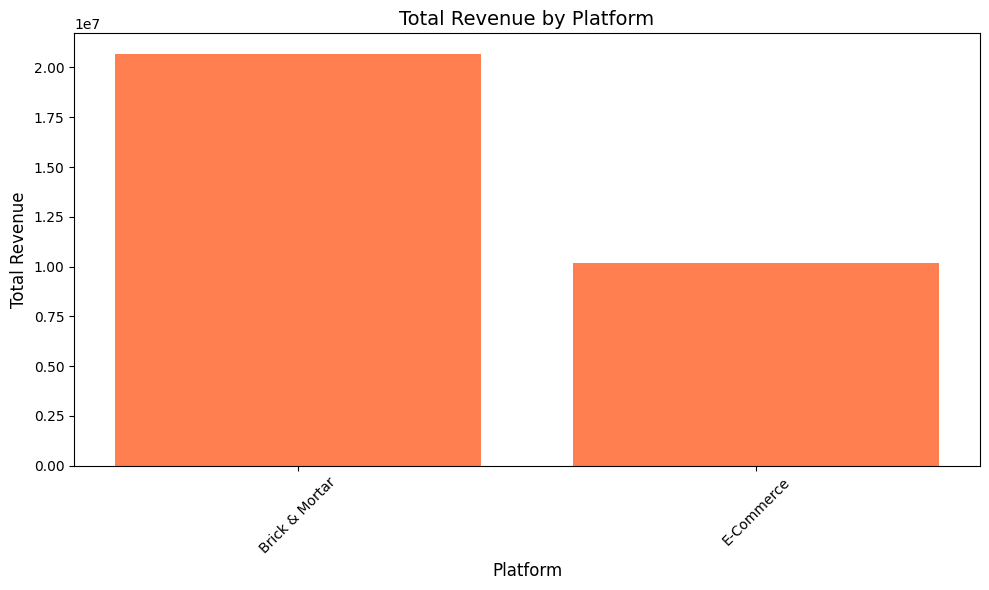

In [15]:
#plot for total revenue by platform
plt.figure(figsize=(10, 6))
plt.bar(segment_revenue['platform'], segment_revenue['total_revenue'], color='coral')
plt.title('Total Revenue by Platform', fontsize=14)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This chart shows which platform is more profitable.

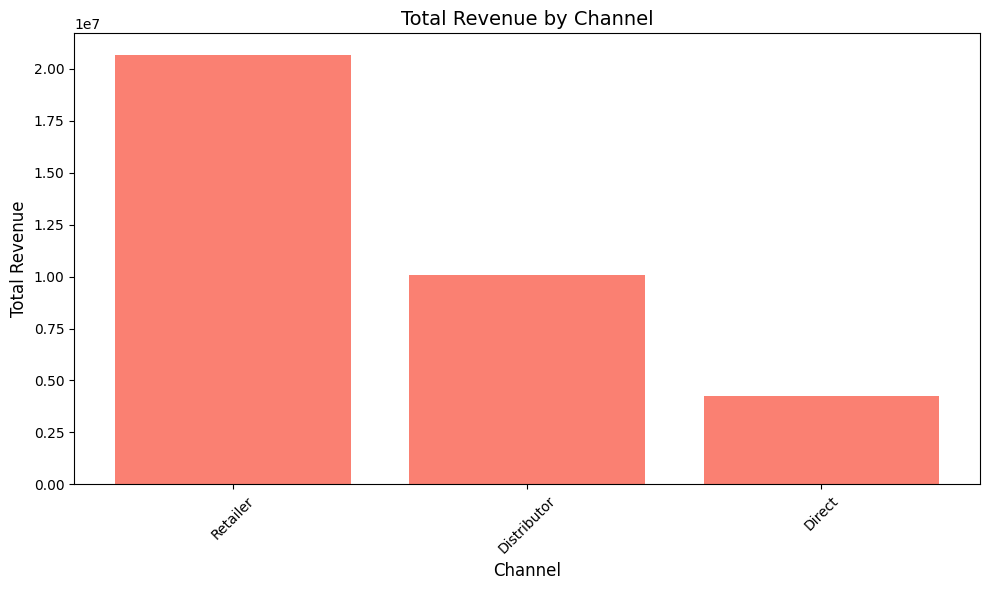

In [16]:
#plot for total revenue by channel
plt.figure(figsize=(10, 6))
plt.bar(segment_revenue['channel'], segment_revenue['total_revenue'], color='salmon')
plt.title('Total Revenue by Channel', fontsize=14)
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This chart shows which channel generates the most income for the company.

**Customer Segments with the Highest CLV**

In [17]:
query = """
SELECT 
    dc.customer_code,
    dc.customer,
    dc.region,
    dc.platform,
    dc.channel,
    SUM(fsm.sold_quantity * fgp.gross_price) AS customer_lifetime_value
FROM fact_sales_monthly fsm
JOIN dim_customer dc ON fsm.customer_code = dc.customer_code
JOIN fact_gross_price fgp ON fsm.product_code = fgp.product_code AND fsm.fiscal_year = fgp.fiscal_year
GROUP BY dc.customer_code
ORDER BY customer_lifetime_value DESC
LIMIT 10;
"""


top_clv_customers = pd.read_sql_query(query, conn)
print(top_clv_customers.head())

   customer_code  customer region        platform      channel  \
0       80007195      Sage   APAC  Brick & Mortar  Distributor   
1       80007196    Leader   APAC  Brick & Mortar  Distributor   
2       90002008    Amazon   APAC      E-Commerce     Retailer   
3       90002009  Flipkart   APAC      E-Commerce     Retailer   
4       80001019   Neptune   APAC  Brick & Mortar  Distributor   

   customer_lifetime_value  
0             2.782356e+06  
1             2.753139e+06  
2             2.332788e+06  
3             1.678228e+06  
4             1.623534e+06  


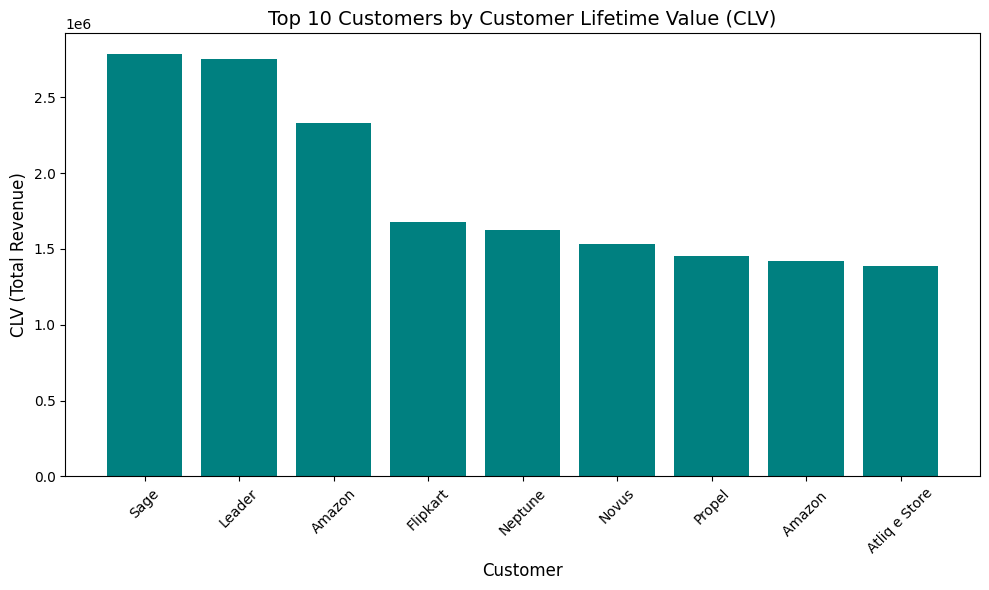

In [18]:
#plot for top 10 customers by CLV
plt.figure(figsize=(10, 6))
plt.bar(top_clv_customers['customer'], top_clv_customers['customer_lifetime_value'], color='teal')
plt.title('Top 10 Customers by Customer Lifetime Value (CLV)', fontsize=14)
plt.xlabel('Customer', fontsize=12)
plt.ylabel('CLV (Total Revenue)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The chart shows the customers who have generated the most revenue for the company over time. 

These customers are critical for the business as they provide significant value.

Focusing on high-CLV customers can help the company drive more revenue.

**PURCHASING BEHAVIOR**

**How many products were sold each month**

In [19]:
query = """
SELECT 
    strftime('%Y-%m', fsm.date) AS month,
    SUM(fsm.sold_quantity) AS total_sold_quantity
FROM fact_sales_monthly fsm
GROUP BY month
ORDER BY month;
"""
purchasing_patterns = pd.read_sql_query(query, conn)

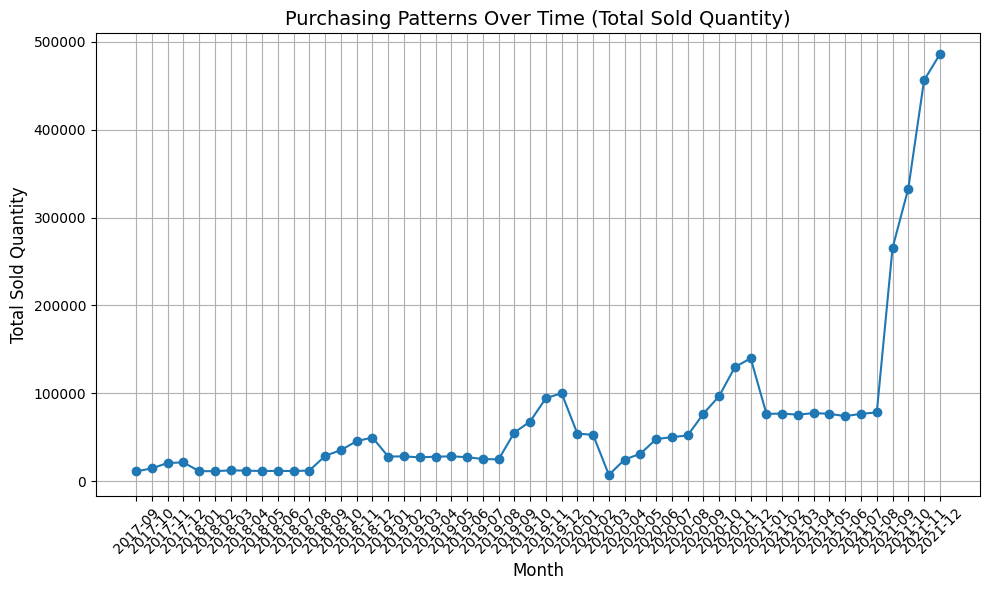

In [20]:
#plot for purchasing patterns
plt.figure(figsize=(10, 6))
plt.plot(purchasing_patterns['month'], purchasing_patterns['total_sold_quantity'], marker='o')
plt.title('Purchasing Patterns Over Time (Total Sold Quantity)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sold Quantity', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

This chart shows how the total number of products sold has changed over time (month by month). 

It helps identify peak periods of sales and any seasonal trends.

**Average size of each order per month**

In [21]:
query = """
SELECT 
    strftime('%Y-%m', fsm.date) AS month,
    AVG(fsm.sold_quantity) AS average_order_size
FROM fact_sales_monthly fsm
GROUP BY month
ORDER BY month;
"""
average_order_size = pd.read_sql_query(query, conn)

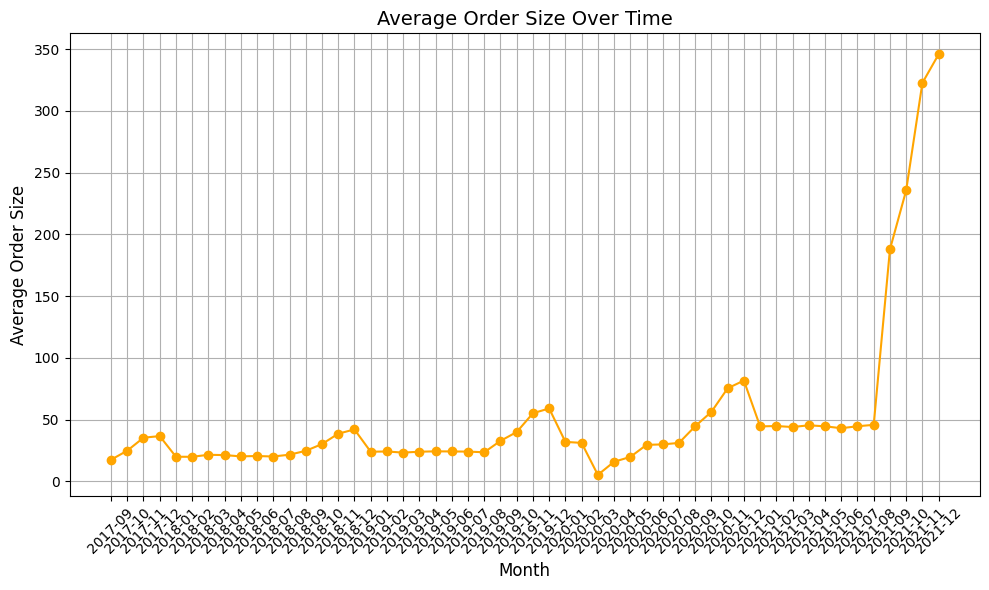

In [22]:
#plot for average size of each order per month
plt.figure(figsize=(10, 6))
plt.plot(average_order_size['month'], average_order_size['average_order_size'], marker='o', color='orange')
plt.title('Average Order Size Over Time', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Order Size', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

The average number of items customers buy in a single order is calculated for each month. 

By analyzing this, we can see if customers are buying more or fewer items over time.

**Number of Orders Per Month**

In [23]:
query = """
SELECT 
    strftime('%Y-%m', fsm.date) AS month,
    COUNT(DISTINCT fsm.customer_code) AS order_count
FROM fact_sales_monthly fsm
GROUP BY month
ORDER BY month;
"""
purchase_frequency = pd.read_sql_query(query, conn)

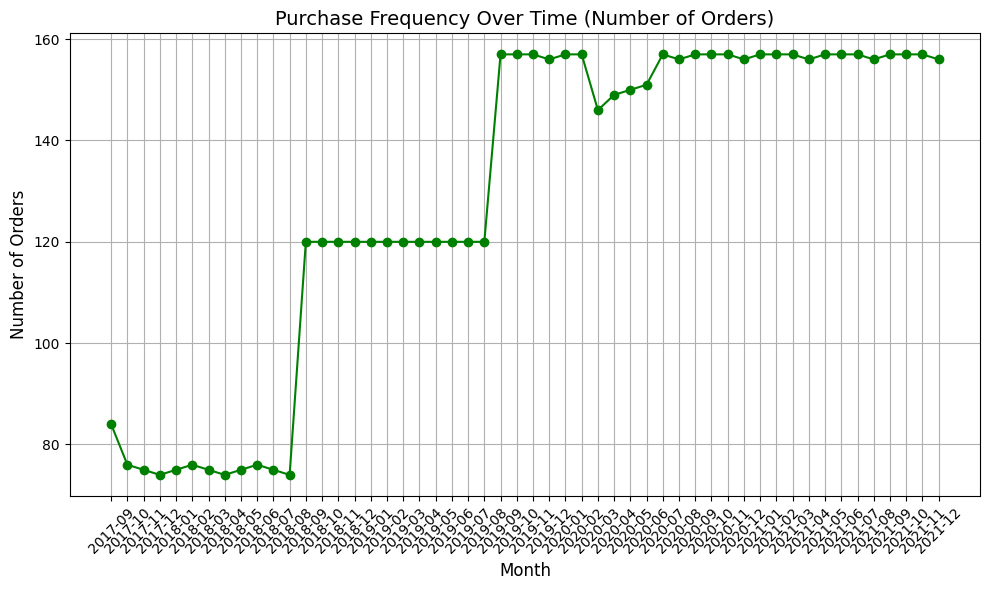

In [24]:
#plot for number of orders per month
plt.figure(figsize=(10, 6))
plt.plot(purchase_frequency['month'], purchase_frequency['order_count'], marker='o', color='green')
plt.title('Purchase Frequency Over Time (Number of Orders)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

This chart shows how often customers are placing orders each month. 

It shows whether the number of customers making purchases is increasing or decreasing over time.

**PRODUCT PREFERENCES**

**Most Popular Product Categories**

In [25]:
query = """
SELECT 
    dp.category,
    SUM(fsm.sold_quantity) AS total_quantity_sold
FROM fact_sales_monthly fsm
JOIN dim_product dp ON fsm.product_code = dp.product_code
GROUP BY dp.category
ORDER BY total_quantity_sold DESC;
"""
popular_categories = pd.read_sql_query(query, conn)

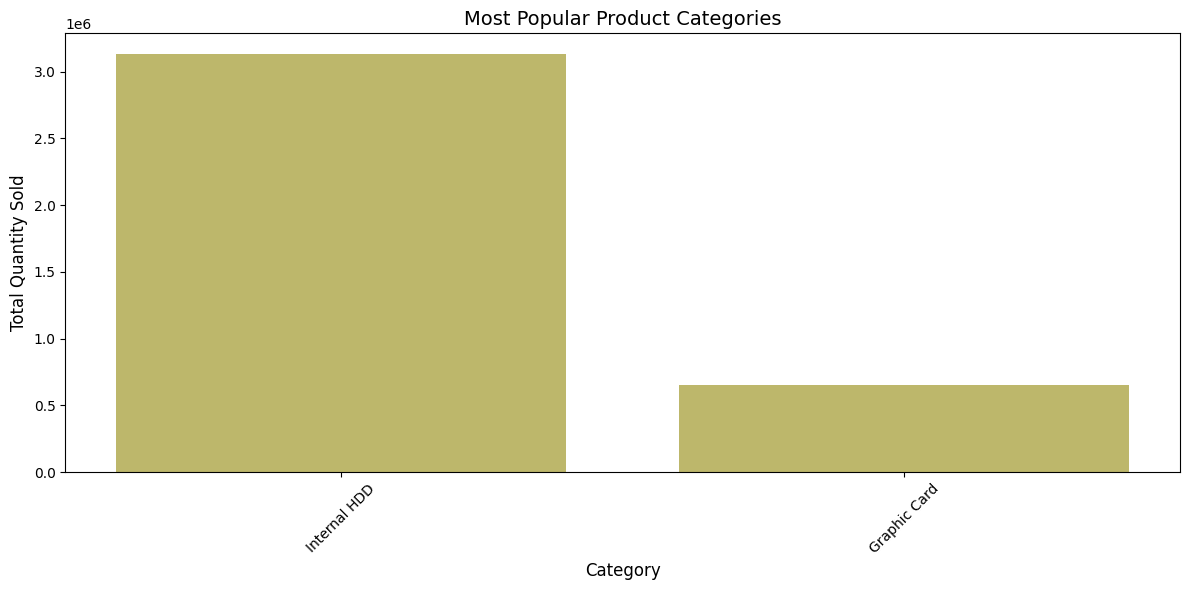

In [26]:
#bar chart for the most popular categories
plt.figure(figsize=(12, 6))
plt.bar(popular_categories['category'], popular_categories['total_quantity_sold'], color='darkkhaki')
plt.title('Most Popular Product Categories', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Quantity Sold', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The bar chart above visualizes the most popular product categories based on total sold quantity. 

The category Internal HDD is the most popular.

**Product Preferences by Region and Platform**

In [27]:
query = """
SELECT 
    dc.region, 
    dc.platform, 
    dc.channel, 
    dp.category, 
    SUM(fsm.sold_quantity) AS total_quantity_sold
FROM fact_sales_monthly fsm
JOIN dim_customer dc ON fsm.customer_code = dc.customer_code
JOIN dim_product dp ON fsm.product_code = dp.product_code
GROUP BY dc.region, dc.platform, dc.channel, dp.category
ORDER BY total_quantity_sold DESC;
"""

preferences_region_platform_channel = pd.read_sql_query(query, conn)

summary_detailed = preferences_region_platform_channel.groupby(['region', 'platform', 'channel', 'category'])['total_quantity_sold'].sum().reset_index()
summary_detailed.sort_values(by='total_quantity_sold', ascending=False, inplace=True)

print(summary_detailed.head(20))

   region        platform      channel      category  total_quantity_sold
5    APAC  Brick & Mortar     Retailer  Internal HDD             743946.0
13     EU  Brick & Mortar     Retailer  Internal HDD             497750.0
27     NA  Brick & Mortar     Retailer  Internal HDD             379906.0
9    APAC      E-Commerce     Retailer  Internal HDD             366033.0
3    APAC  Brick & Mortar  Distributor  Internal HDD             360075.0
31     NA      E-Commerce     Retailer  Internal HDD             194632.0
4    APAC  Brick & Mortar     Retailer  Graphic Card             162340.0
7    APAC      E-Commerce       Direct  Internal HDD             153636.0
1    APAC  Brick & Mortar       Direct  Internal HDD             129686.0
12     EU  Brick & Mortar     Retailer  Graphic Card              88678.0
2    APAC  Brick & Mortar  Distributor  Graphic Card              83211.0
8    APAC      E-Commerce     Retailer  Graphic Card              82055.0
17     EU      E-Commerce     Retailer

**APAC Region:**
The most popular way to buy products is through Brick & Mortar stores, especially from Retailers, with 743946 units sold. E-Commerce platforms are also popular, with 366033 units sold through Retailers.

**EU Region:**
Brick & Mortar stores are the top choice, with 497750 units sold through Retailers.

**NA Region:**
Like APAC and EU, Brick & Mortar stores, especially Retailers, are the most preferred, with 379906 units sold.

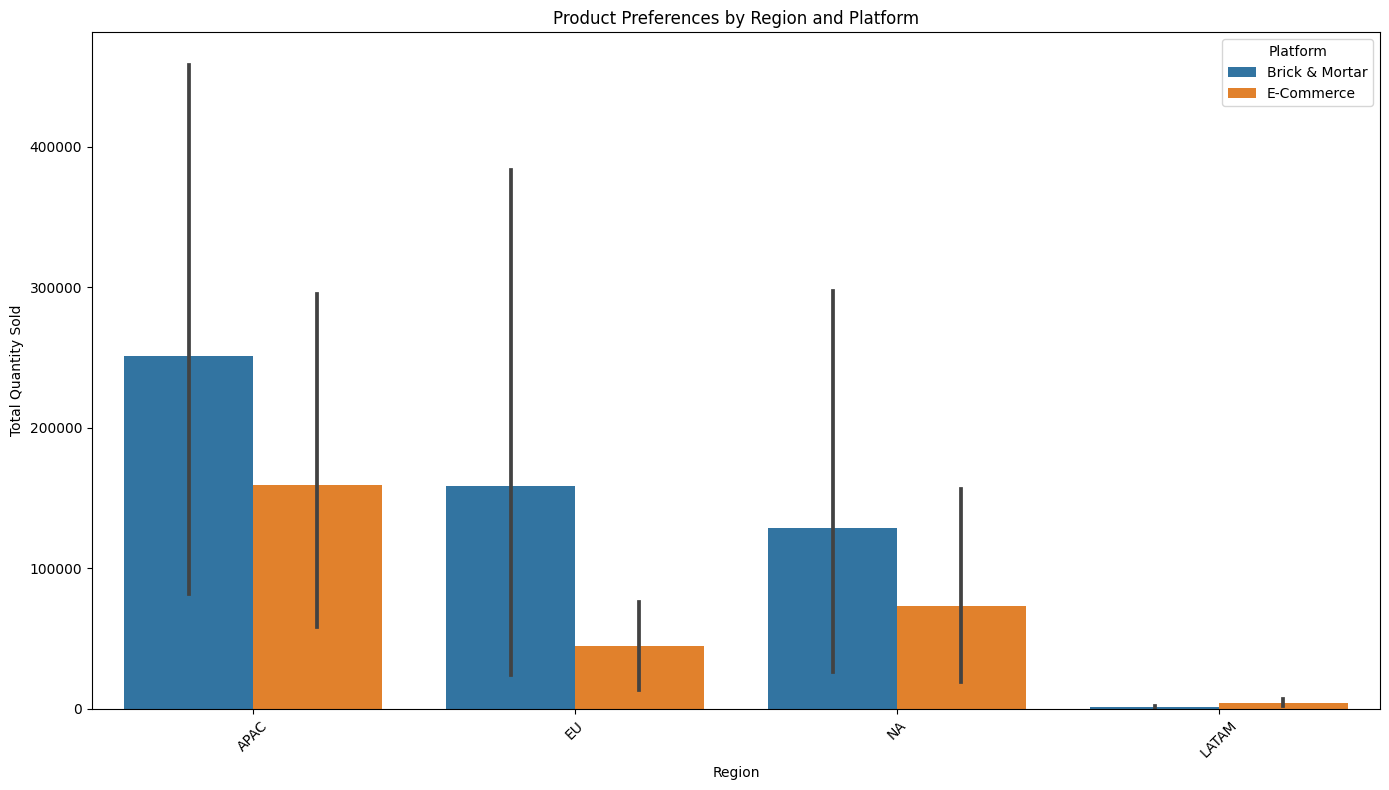

In [28]:
plt.figure(figsize=(14, 8))
sns.barplot(data=preferences_region_platform_channel, 
            x='region', 
            y='total_quantity_sold', 
            hue='platform')

plt.title('Product Preferences by Region and Platform')
plt.ylabel('Total Quantity Sold')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.tight_layout()
plt.show()

The bar chart shows total sold quantities across different regions (e.g., APAC, EU, NA) and platforms (e.g., Brick & Mortar, E-Commerce).

**Product Preferences by Region and Channel**

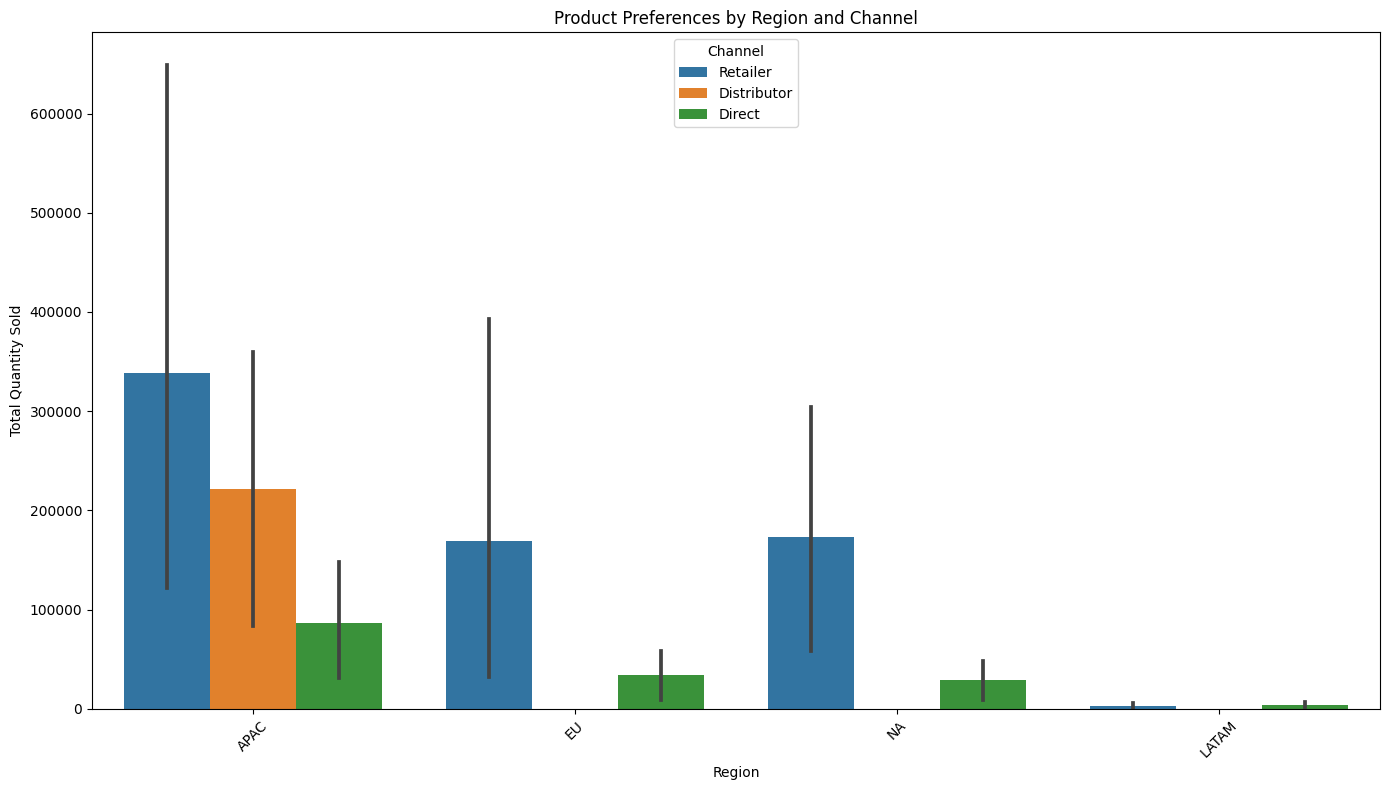

In [29]:
plt.figure(figsize=(14, 8))
sns.barplot(data=preferences_region_platform_channel, 
            x='region', 
            y='total_quantity_sold', 
            hue='channel')

plt.title('Product Preferences by Region and Channel')
plt.ylabel('Total Quantity Sold')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.legend(title='Channel')
plt.tight_layout()
plt.show()

**Conclusions:**

The most popular product category is Internal HDD, with the highest sales across all regions, platforms, and channels.

Brick & Mortar stores drive the most sales across regions, especially in the APAC and EU regions.

E-Commerce platforms are growing in the APAC region but aren’t as strong as Brick & Mortar.

Retailers are the dominant sales channel, followed by Distributors.

The APAC region leads in overall sales, with Retailers playing a major role.


**HYPOTHESES**

**Hypothesis 1: Customers who shop through the E-Commerce platform spend more than those who buy through physical stores.**

**H0:** The average spending of customers on the E-Commerce platform is equal to or less than that of customers who shop in physical stores.

**H1:** The average spending of customers on the E-Commerce platform is higher than that of customers who shop in physical stores.

In [30]:
sales_query = "SELECT * FROM fact_sales_monthly LIMIT 5;"
sales_data = pd.read_sql(sales_query, conn)

sales_data

,date,product_code,customer_code,sold_quantity,fiscal_year
0,2017-09-01,A0118150101,70002017.0,51.0,2018.0
1,2017-09-01,A0118150101,70002018.0,77.0,2018.0
2,2017-09-01,A0118150101,70003181.0,17.0,2018.0
3,2017-09-01,A0118150101,70003182.0,6.0,2018.0
4,2017-09-01,A0118150101,70006157.0,5.0,2018.0


In [31]:
customer_query = "SELECT * FROM dim_customer LIMIT 5;"
customer_data = pd.read_sql(customer_query, conn)

customer_data

,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC


In [32]:
sales_platform_query = """
SELECT c.platform, SUM(f.sold_quantity) as total_sales
FROM fact_sales_monthly f
JOIN dim_customer c ON f.customer_code = c.customer_code
GROUP BY c.platform;
"""

sales_platform_data = pd.read_sql(sales_platform_query, conn)
sales_platform_data

,platform,total_sales
0,Brick & Mortar,2657627.0
1,E-Commerce,1125308.0


E-Commerce customers have a total of 1,125,308 units sold.

Brick & Mortar customers have a total of 2,657,627 units sold.

In [33]:
avg_sales_query = """
SELECT c.platform, AVG(f.sold_quantity) as avg_sales_per_customer
FROM fact_sales_monthly f
JOIN dim_customer c ON f.customer_code = c.customer_code
GROUP BY c.customer_code, c.platform;
"""

avg_sales_data = pd.read_sql(avg_sales_query, conn)
avg_sales_data.head()

,platform,avg_sales_per_customer
0,Brick & Mortar,137.598446
1,E-Commerce,158.388601
2,Brick & Mortar,67.352332
3,E-Commerce,70.784974
4,Brick & Mortar,13.856481


In [34]:
brick_and_mortar_sales = avg_sales_data[avg_sales_data['platform'] == 'Brick & Mortar']['avg_sales_per_customer']
ecommerce_sales = avg_sales_data[avg_sales_data['platform'] == 'E-Commerce']['avg_sales_per_customer']

#t-test
t_stat, p_value = ttest_ind(brick_and_mortar_sales, ecommerce_sales, equal_var=False)
t_stat, p_value

(-0.3843321357068101, 0.7015002424727363)

The t-test results show:

t-statistic: -0.38

p-value: 0.70

Since the p-value is much higher than 0.05, we fail to reject the null hypothesis.

This means there is no statistically significant difference in the average amount spent by customers on the E-Commerce platform compared to physical stores.

**Hypothesys 2: Customers who buy frequently are the most valuable customers and generate the
most revenue.**

**H0:** There is no correlation between the frequency of purchases and the total revenue generated by a customer.

**H1:** Customers who buy more frequently generate more revenue.

In [35]:
customer_value_query = """
SELECT f.customer_code, COUNT(f.sold_quantity) as purchase_frequency, SUM(f.sold_quantity) as total_sales
FROM fact_sales_monthly f
GROUP BY f.customer_code;
"""

customer_value_data = pd.read_sql(customer_value_query, conn)
customer_value_data.head()

,customer_code,purchase_frequency,total_sales
0,70002017.0,386,53113.0
1,70002018.0,386,61138.0
2,70003181.0,386,25998.0
3,70003182.0,386,27323.0
4,70004069.0,216,2993.0


In [36]:
customer_value_data_cleaned = customer_value_data.dropna()

correlation = customer_value_data_cleaned['purchase_frequency'].corr(customer_value_data_cleaned['total_sales'])
correlation

0.5372717962707253

The correlation between purchase frequency and total sales is 0.54, indicating a moderate positive relationship. This suggests that customers who buy more frequently do tend to generate more revenue.

**Hypothesys 3: Customers who buy directly from AtliQ Hardware purchase in larger quantities
compared to those buying through distributors or retailers.**

**H0:** The average quantity purchased by customers who buy directly from AtliQ Hardware is equal to or less than that of customers buying from distributors or retailers.

**H1**: The average quantity purchased by customers who buy directly from AtliQ Hardware is larger than that of customers buying from distributors or retailers.

In [37]:
direct_vs_distributor_query = """
SELECT c.channel, AVG(f.sold_quantity) as avg_purchase_quantity
FROM fact_sales_monthly f
JOIN dim_customer c ON f.customer_code = c.customer_code
GROUP BY c.channel;
"""

direct_vs_distributor_data = pd.read_sql(direct_vs_distributor_query, conn)
direct_vs_distributor_data

,channel,avg_purchase_quantity
0,Direct,45.748828
1,Distributor,230.158879
2,Retailer,52.488542


Direct customers have an average purchase quantity of 45.75.

Distributor customers have a significantly higher average purchase quantity of 230.16.

Retailer customers have an average purchase quantity of 52.49.

Contrary to the hypothesis, customers buying through distributors tend to purchase in much larger quantities compared to direct buyers.

**CONCLUSIONS for AtliQ Hardware:**

Customer Segments: Distributor customers buy in larger quantities and are a key revenue source. Based on sales data, Distributors accounted for the majority of total order size across multiple regions, especially in APAC and EU. High-CLV (Customer Lifetime Value) segments are especially valuable.

Purchasing Trends: No significant difference in spending between E-Commerce and physical stores. This indicates that both platforms are equally valuable. Frequent buyers generate more revenue.

Product Preferences: Internal HDD was consistently the most popular product category across regions. For instance, in the APAC region, Internal HDDs accounted for over 35% of total sales. Distributors purchased in larger quantities due to potential bulk discounts. In APAC, distributors bought 743,946 units of Internal HDDs.

Hypotheses: E-Commerce and physical store customers spend similarly. Frequent buyers are more valuable.

**RECOMENDATIONS for AtliQ Hardware:**

Focus on High-Value Customers: Target distributor channels with bulk discounts and offer loyalty programs for high-CLV customers.

Grow Both Platforms: Boost total customers across both E-Commerce and physical stores, rather than shifting between platforms.

Maximize Profit: Ensure popular products align with profit goals and adjust pricing or promotions if needed.

Retention Strategies: Implement loyalty programs for frequent buyers and offer incentives for regions with lower CLV.

Explore New Markets: Launch region-specific products and campaigns to capture untapped opportunities.

In [38]:
conn = sqlite3.connect('atliq_db.sqlite3')
df_customer = pd.read_sql_query("SELECT * FROM dim_customer", conn)
df_customer.to_csv('dim_customer.csv', index=False)
conn.close()

In [39]:
conn = sqlite3.connect('atliq_db.sqlite3')
df_product = pd.read_sql_query("SELECT * FROM dim_product", conn)
df_product.to_csv('dim_product.csv', index=False)
conn.close()

In [40]:
conn = sqlite3.connect('atliq_db.sqlite3')
df_sales = pd.read_sql_query("SELECT * FROM fact_sales_monthly", conn)
df_sales.to_csv('fact_sales_monthly.csv', index=False)
conn.close()

In [41]:
conn = sqlite3.connect('atliq_db.sqlite3')
df_price = pd.read_sql_query("SELECT * FROM fact_gross_price", conn)
df_price.to_csv('fact_gross_price.csv', index=False)
conn.close()